# Análise preditiva do Programa Mais Médicos

## 1. Análise preditiva para desfecho categórico (churn)

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE



### Carregamento dos dados

In [24]:
df = pd.read_csv('C:\\Users\\Lapei_Cigets\\Documents\\GitHub\\sa_maismedicos\\01_dados\\dados resultantes\\df_modelagem.csv')

df = df.drop(["Unnamed: 0",
              "meses_no_local_alocado"], 
             axis='columns')

df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']] = df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']].fillna(0)
df['churn'] = df['churn'].map({'permanece': 0, 'migrou': 1})

In [25]:
df.head()

,churn,idade,atuacao_previa_no_municipio,anos_atuacao_previa_no_municipio,media_vinculos_mes,Prorrogado,m_agente_saude,m_tec_aux_enf,m_enfermeiro,m_dentista,...,variacao_pib,tx_pop_ocupada_2019,orcamento_saude,esgotamento_sanitario,taxa_homicidio,ideb_anosfinais,investimento_infraestrutura,equipamentos_esportivos,equipamentos_culturais,distancia_capital
0,0,35,Não,0.0,2.343284,NÃO,9.473684,8.513158,4.815789,0.000000,...,66,11.356216,366.57,0.0,33.946,4.3,103.676,5.703,9.125,636.0
1,1,30,Não,0.0,1.000000,NÃO,13.375000,1.000000,1.625000,1.000000,...,61,15.844714,683.09,0.0,64.522,4.7,5021.768,18.540,4.635,114.0
2,0,75,Não,0.0,1.000000,SIM,9.411765,3.562500,1.889706,1.338235,...,120,8.658503,626.30,0.0,37.161,4.6,3097.942,0.000,4.144,147.0
3,1,37,Não,0.0,1.000000,NÃO,7.771429,1.000000,1.000000,0.000000,...,111,3.407013,457.94,0.0,19.552,5.3,3190.453,2.464,4.928,155.0
4,1,62,Não,0.0,1.000000,SIM,5.328358,2.014925,1.000000,1.000000,...,109,17.059704,614.94,0.0,24.491,4.0,4048.908,12.291,4.097,158.0


### Pré-processamento

In [26]:
y = df['churn']  
X = df.drop(columns=['churn']) 

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


## Dividindo em treino e teste

In [30]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Aplicar o pré-processamento nos dados de treino antes do SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Aplicação do SMOTE para balanceamento
smote = SMOTE(sampling_strategy='auto', random_state=42)
y_train = y_train.astype(int)  # Garantir que y_train seja numérico
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

## Instanciando modelos e rodando modelos

In [33]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 10]},
    'Random Forest': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__subsample': [0.7, 0.85, 1.0],
        'classifier__colsample_bytree': [0.7, 0.85, 1.0],
        'classifier__gamma': [0, 0.1, 0.5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [20, 31, 40],
        'classifier__min_child_samples': [10, 20, 30]
    }
}

# Validação cruzada e otimização de hiperparâmetros
best_models = {}

for name, model in models.items():
    print(f"Treinando modelo: {name}")
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    param_grid = param_grids.get(name, {})
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}\n")

# Avaliação final no conjunto de teste
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

Treinando modelo: Logistic Regression
Melhores parâmetros para Logistic Regression: {'classifier__C': 0.1}

Treinando modelo: Decision Tree
Melhores parâmetros para Decision Tree: {'classifier__max_depth': 3}

Treinando modelo: Random Forest
Melhores parâmetros para Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}

Treinando modelo: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:59:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros para XGBoost: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 9, 'classifier__n_estimators': 500, 'classifier__subsample': 0.85}

Treinando modelo: LightGBM
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,006921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
Melhores parâmetros para LightGBM: {'classifier__learning_rate': 0.05, 'classifier__min_child_samples': 10, 'classifier__n_estimators': 500, 'classifier__num_leaves': 31}



In [34]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC AUC', ascending=False))

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
2        Random Forest  0.763578   0.881279  0.800830  0.839130  0.817716
3              XGBoost  0.731629   0.839827  0.804979  0.822034  0.803366
0  Logistic Regression  0.699681   0.920000  0.668050  0.774038  0.794836
4             LightGBM  0.734824   0.826446  0.829876  0.828157  0.774205
1        Decision Tree  0.686901   0.933333  0.639004  0.758621  0.761180


In [35]:
best_model_name = results_df.sort_values(by='ROC AUC', 
                                         ascending=False).iloc[0]['Model']

best_model = best_models[best_model_name]


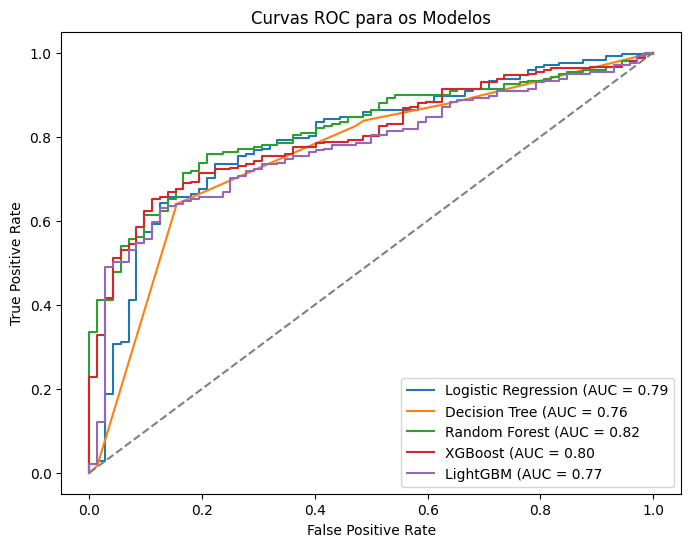

In [37]:
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para os Modelos')
plt.legend()
plt.show()

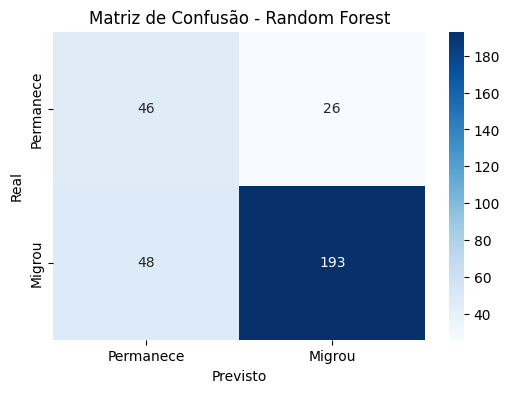

In [38]:
y_pred_best = best_model.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


Melhor limiar: 0.3833902915577487 com F1 Score: 0.8732394366197183


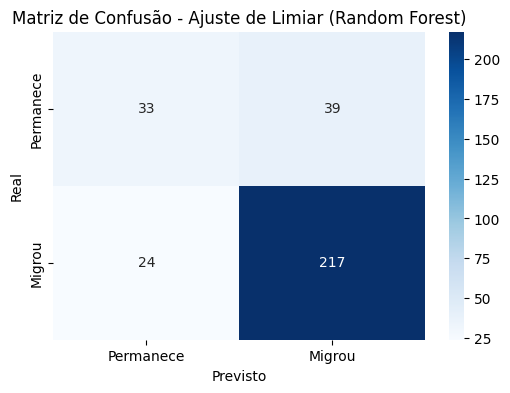

In [43]:
# Ajuste de limiar
y_prob_best = best_model.predict_proba(X_test_processed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_best)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_best >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [40]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.7617853849700323
Precision:  0.9367816091954023
Accuracy:  0.7156549520766773
Recall:  0.6763485477178424
F1 Score:  0.8281573498964804
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


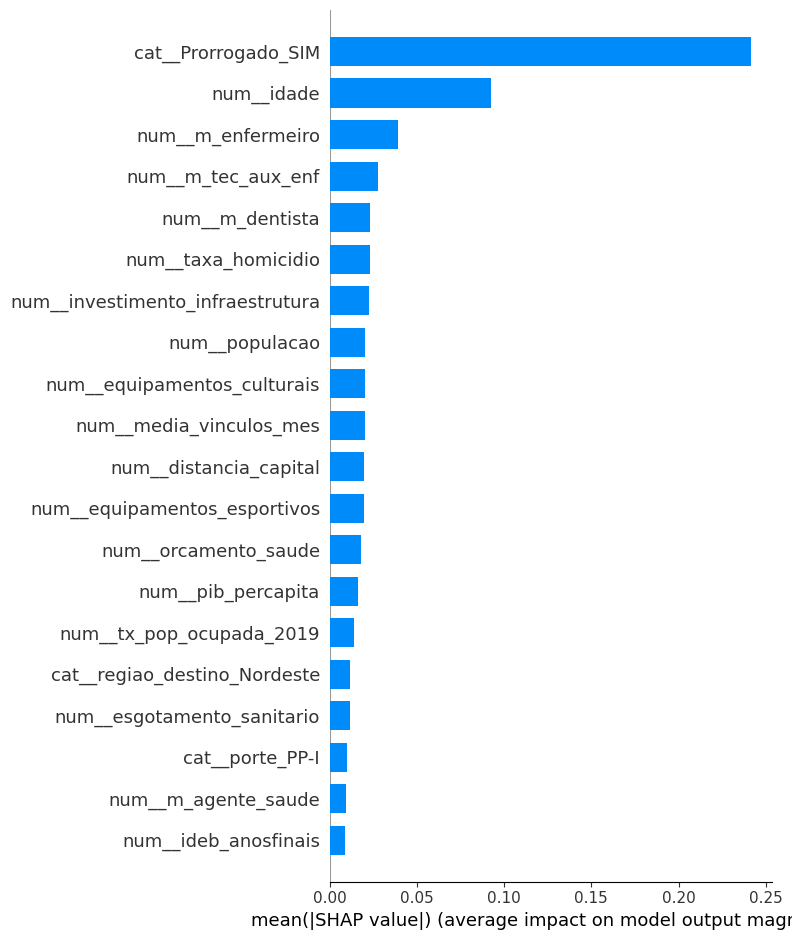

In [46]:
shap.summary_plot(shap_values, features= X_transformed, 
                  feature_names= X_transformed.columns, 
                  plot_type="bar")


PermutationExplainer explainer: 314it [04:39,  1.08it/s]                         


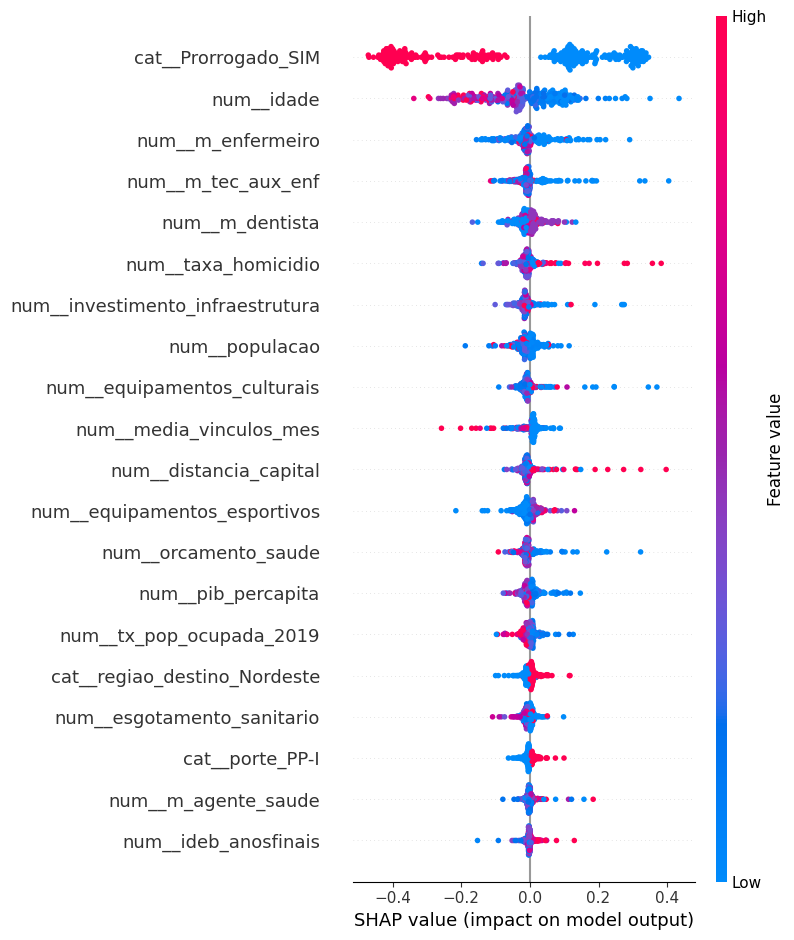

In [45]:
# Criar explicação do SHAP para o melhor modelo
explainer = shap.Explainer(best_model.predict, 
                           X_test_processed)

shap_values = explainer(X_test_processed)

# Gerar gráfico de resumo do SHAP
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, 
                  X_test_processed, 
                  feature_names=feature_names)

O código abaixo é usado para treinar o modelo com a base completa

PermutationExplainer explainer: 1565it [25:27,  1.02it/s]                          


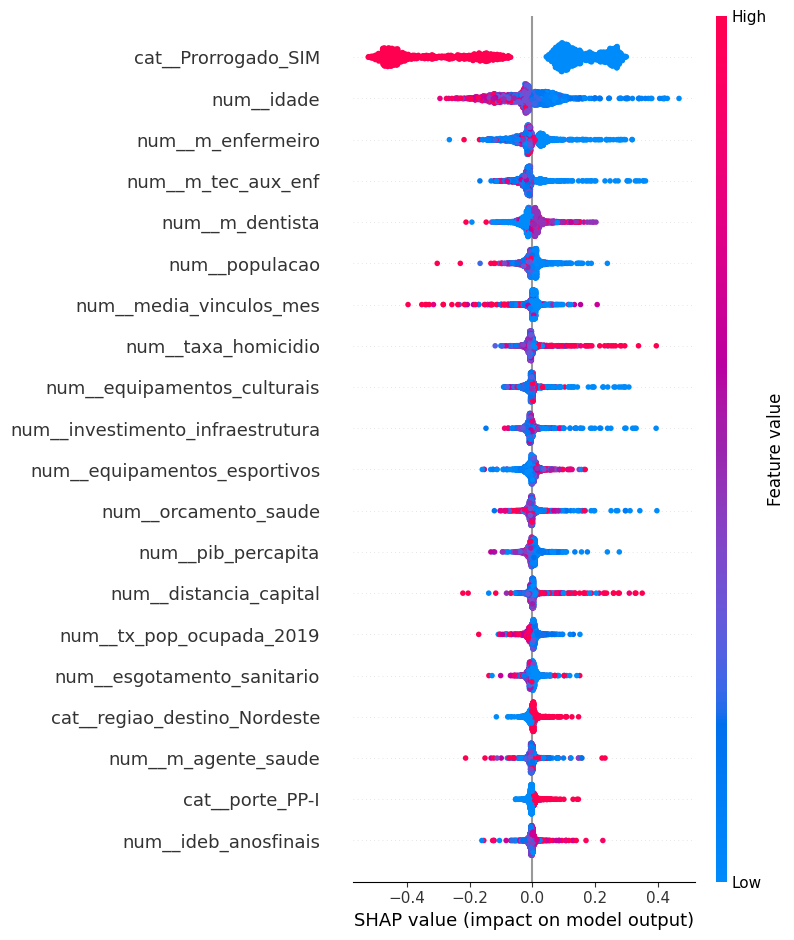

PermutationExplainer explainer: 314it [05:03,  1.00s/it]                         


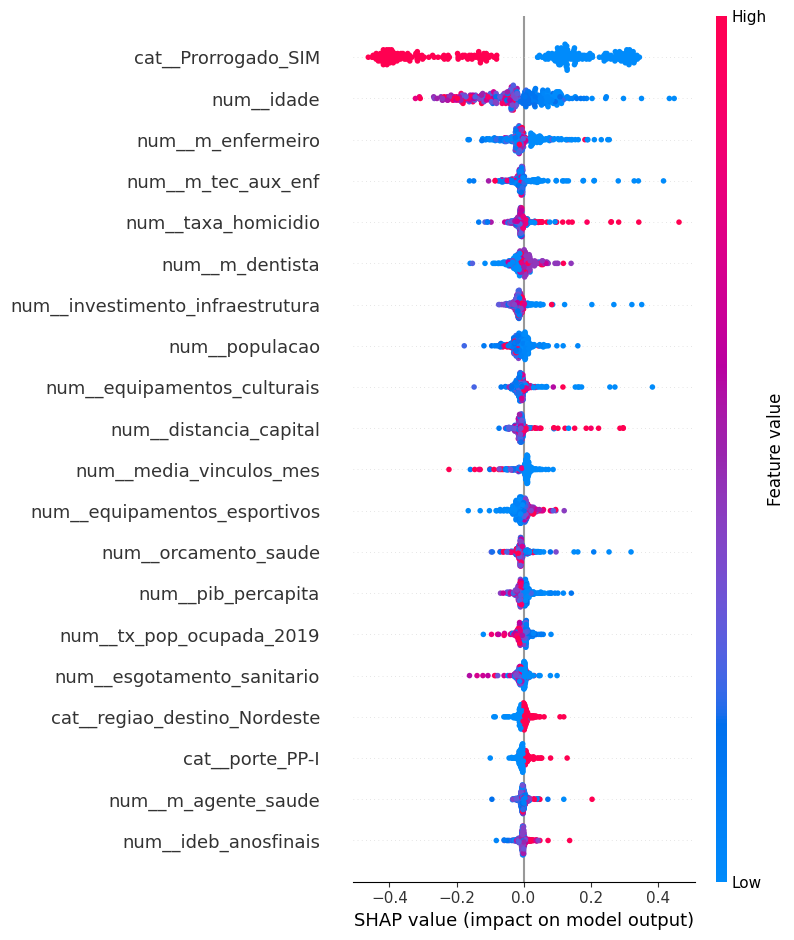

In [ ]:
# Criar explicação do SHAP para o melhor modelo
explainer_full = shap.Explainer(best_model.predict, preprocessor.transform(X))
shap_values_full = explainer_full(preprocessor.transform(X))

# Gerar gráfico de resumo do SHAP para a base completa
shap.summary_plot(shap_values_full, preprocessor.transform(X), feature_names=feature_names)
explainer = shap.Explainer(best_model.predict, X_test_processed)
shap_values = explainer(X_test_processed)